# Sea level budget

In [1]:
import numpy as np
import SeaLevelContrib as slc
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import IPython.display
import importlib
import netCDF4
import xarray as xr

/Users/dewilebars/anaconda3/envs/p37ds/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
importlib.reload(slc)

<module 'SeaLevelContrib' from '/Users/dewilebars/Projects/Project_SeaLevelBudgets/Notebooks/SeaLevelContrib.py'>

In [3]:
path_outputs = '../outputs/'

In [4]:
# ZSM: [20, 22, 23, 24, 25, 32]
# North Sea Frederikse et al. 2016 ('NS_Fred16'): 
# [20, 32, 236, 7, 80, 89, 302, 47, 830, 361, 95, 754]
# Newlyn: [202], Brest: [1], Vlissingen: [20]
reg_name = 'ZSM'
tg_id = [20, 22, 23, 24, 25, 32]
tg_df = slc.tide_gauge_obs(tg_id, interp=True)
tg_df.iloc[-10:]

,20,22,23,24,25,32,Average
time,,,,,,,
2009,12.172611,14.848387,8.513636,10.288312,7.905195,9.902721,10.605144
2010,12.372611,15.748387,7.213636,8.888312,5.705195,8.702721,9.771810
2011,12.772611,16.348387,11.913636,14.388312,12.305195,11.802721,13.255144
2012,12.072611,16.348387,10.413636,12.788312,11.005195,11.202721,12.305144
2013,10.672611,14.748387,7.513636,10.388312,6.705195,8.802721,9.805144
2014,14.472611,17.848387,10.813636,14.788312,12.005195,13.502721,13.905144
2015,14.772611,18.648387,13.813636,20.088312,16.705195,14.902721,16.488477
2016,15.072611,18.848387,11.913636,16.588312,13.005195,14.202721,14.938477
2017,16.672611,21.048387,15.813636,22.388312,17.605195,17.202721,18.455144


In [6]:
steric_df = slc.StericSL(max_depth=4000, mask_name='ENS') # ENS, EBB, NWS

for i in range(len(tg_id)):
    print('Working on tide gauge id: '+ str(tg_id[i]))
    gia_ts_df = slc.GIA_ICE6G([tg_id[i]])
    #glac_ts_df = slc.glaciers_m15([tg_id[i]], extrap=True, del_green=True)
    glac_ts_df = slc.glaciers_zemp19([tg_id[i]], extrap=True, del_green=True)
    ant_df = slc.ant_rignot19_glo() * slc.ices_fp([tg_id[i]] , 'mit_unif', 
                                                  'ant') #imbie or rignot19
    #ant_df = slc.ant_imbie_glo(extrap=True) * slc.ices_fp(tg_id, 'mit_unif', 'ant')
    green_df = slc.green_mouginot19_glo() * slc.ices_fp([tg_id[i]] , 'mit_unif', 
                                                        'green')
    sealevel_df = steric_df
    tws_df = slc.TWS_glo(extrap=True)
    sealevel_df = sealevel_df.join([gia_ts_df, glac_ts_df, ant_df, green_df, 
                                    tws_df], how='inner') # how='inner'
    
    sealevel_df['Total'] = sealevel_df.sum(axis=1)

    diff_tg_df = tg_df.Average - sealevel_df.Total
    diff_tg_df = diff_tg_df.to_frame(name='height').dropna()
    wpn_ef_df = slc.make_wpn_ef([tg_id[i]], diff_tg_df, with_trend=False, 
                                product='ERA5') # NCEP1 or ERA5
#     wpn_ef_df = slc.make_waqua_df(tg_id[i])
    
    sealevel_df = sealevel_df.join(wpn_ef_df, how='inner')
    del sealevel_df['Total']
    #sealevel_df['Total'] = sealevel_df.sum(axis=1)
    sealevel_df.insert(0, 'Total', sealevel_df.sum(axis=1))
    sealevel_df['Total'] = sealevel_df['Total'] - sealevel_df['Total'].mean()
    sealevel_df.index.name = 'time'
    sealevel_df = sealevel_df - sealevel_df.iloc[0,:]
    sealevel_df = pd.concat([sealevel_df], axis=1, keys=[str(tg_id[i])])

    if i==0:
        slall_df = sealevel_df.copy()
    else:
        slall_df = pd.concat([slall_df, sealevel_df], axis=1)
        
slall_df.iloc[-10:]

/Users/dewilebars/anaconda3/envs/p37ds/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Working on tide gauge id: 20
found point 51.5 3.5
Working on tide gauge id: 22
found point 52.0 4.0
Working on tide gauge id: 23
found point 53.0 4.75
Working on tide gauge id: 24
found point 53.25 7.0
Working on tide gauge id: 25
found point 53.25 5.5
Working on tide gauge id: 32
found point 52.5 4.5


20                                                            \
          Total    Steric    GIA  Glaciers Antarctica Greenland       TWS   
time                                                                        
2009   5.108298  6.060237  0.120  1.061797   0.725974  0.126684  0.404047   
2010   4.013730  6.852622  0.124  1.101909   0.785952  0.142420  0.364924   
2011   8.504221  7.358719  0.128  1.163656   0.849611  0.159688  0.196228   
2012   5.707248  5.395810  0.132  1.210390   0.917078  0.177812  0.507848   
2013   3.192808  6.454923  0.136  1.279726   0.988484  0.193781  0.504573   
2014   7.119763  7.630830  0.140  1.341900   1.063955  0.201350  0.352733   
2015  10.334281  6.553563  0.144  1.434858   1.143622  0.212807  0.385261   
2016   7.635143  7.061321  0.148  1.503981   1.227612  0.224757  0.385261   
2017  13.525529  8.565661  0.152  1.563963   1.316054  0.239016  0.385261   
2018   6.778127  6.798176  0.156  1.623945   1.409077  0.243852  0.385261   

                                    ...         32                             \
         Nodal      Wind  Pressure  ...      Total    Steric    GIA  Glaciers   
time                                ...                                         
2009 -1.714987 -1.356523 -0.318930  ...   5.699373  6.060237  0.930  1.047165   
2010 -1.797976 -3.397797 -0.162324  ...   5.357487  6.852622  0.961  1.085385   
2011 -1.743456  1.615895 -1.224119  ...   8.822336  7.358719  0.992  1.145832   
2012 -1.557583 -0.376876 -0.699231  ...   6.283435  5.395810  1.023  1.192479   
2013 -1.261337 -4.480437 -0.622903  ...   3.632526  6.454923  1.054  1.260043   
2014 -0.888157 -2.938390  0.215542  ...   7.891292  7.630830  1.085  1.321143   
2015 -0.480164  2.378007 -1.437672  ...  11.231963  6.553563  1.116  1.414361   
2016 -0.083413 -1.943765 -0.888610  ...   7.872045  7.061321  1.147  1.481817   
2017  0.257314  2.077988 -1.031728  ...  15.140359  8.565661  1.178  1.540827   
2018  0.503558 -3.669430 -0.672310  ...   7.959627  6.798176  1.209  1.599836   

                                                                   
     Antarctica Greenland       TWS     Nodal      Wind  Pressure  
time                                                               
2009   0.731326  0.109012  0.404047 -1.816581 -1.101471 -0.664362  
2010   0.791746  0.122553  0.364924 -1.866973 -2.480224 -0.473545  
2011   0.855874  0.137412  0.196228 -1.780941  2.313059 -2.395846  
2012   0.923839  0.153008  0.507848 -1.568197 -0.000450 -1.343903  
2013   0.995771  0.166750  0.504573 -1.252753 -4.151735 -1.399046  
2014   1.071799  0.173263  0.352733 -0.870215 -3.212548  0.339288  
2015   1.152053  0.183122  0.385261 -0.463764  3.611941 -2.720574  
2016   1.236662  0.193405  0.385261 -0.079276 -1.725424 -1.828722  
2017   1.325756  0.205675  0.385261  0.239849  3.611428 -1.912099  
2018   1.419465  0.209836  0.385261  0.457589 -2.527983 -1.591554  

[10 rows x 60 columns]

In [7]:
# Compute the average contributors at all tide gauges
slmean_df = slall_df.groupby(level=1, axis=1, sort=False).mean()
slmean_df = slmean_df.join(tg_df.Average, how='inner')
slmean_df = slmean_df.rename(columns={'Average': 'Obs'})
slmean_df['Obs'] = slmean_df['Obs'] - slmean_df['Obs'].iloc[0]

#slmean_df = slmean_df.loc[1958:2014] # Select date to fit Fred16 study.
#slmean_df
slmean_df.iloc[-10:]

#!!! Modify the name if necessary:
#slmean_df.to_csv(path_outputs+'SLBudget_Steric4000m_ERA5_1979_2018.csv')

,Total,Steric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,Wind,Pressure,Obs
time,,,,,,,,,,,
2009,5.823451,6.060237,1.105000,1.043341,0.729029,0.108875,0.404047,-1.811069,-1.169377,-0.646632,5.600000
2010,5.679790,6.852622,1.141833,1.081716,0.789259,0.122399,0.364924,-1.866749,-2.359719,-0.446495,4.766667
2011,8.744517,7.358719,1.178667,1.141764,0.853186,0.137239,0.196228,-1.785079,2.010815,-2.347021,8.250000
2012,6.720887,5.395810,1.215500,1.188110,0.920937,0.152816,0.507848,-1.575280,0.203679,-1.288533,7.300000
2013,4.132086,6.454923,1.252333,1.255499,0.992643,0.166540,0.504573,-1.261033,-3.823807,-1.409585,4.800000
2014,8.127727,7.630830,1.289167,1.316559,1.068433,0.173045,0.352733,-0.877807,-3.130807,0.305575,8.900000
2015,11.514929,6.553563,1.326000,1.409184,1.148434,0.182892,0.385261,-0.468860,3.596083,-2.617628,11.483333
2016,8.433011,7.061321,1.362833,1.476411,1.232778,0.193161,0.385261,-0.080352,-1.376727,-1.821675,9.933333
2017,15.311922,8.565661,1.399667,1.535204,1.321592,0.205416,0.385261,0.243865,3.462902,-1.807645,13.450000


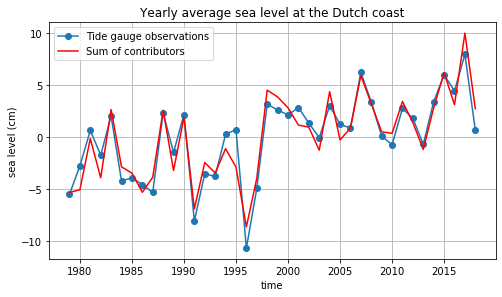

In [8]:
#ys = 1979 #1950 for NCEP1
#ye = 2017

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(slmean_df.Obs - slmean_df.Obs.mean(), 'o-', label='Tide gauge observations')
ax.plot(slmean_df.Total - slmean_df.Total.mean() , 'r-', label='Sum of contributors')
#ax.plot(sealevel_df.index, sealevel_df['Nodal'], 'y-')
#ax.plot(sealevel_df.index, sealevel_df['Glaciers'], '-')
#ax.plot(TWS_df, '-')
ax.set_aspect(1)
#ax.set_xlim([ys,2020])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Yearly average sea level at the Dutch coast')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig('Figures/CompObsContrib.pdf')

Sum of difference (cm) : 
8.881784197001252e-16
Normalised root mean square error (cm): 
0.20429180093424737
Normalised absolute error (cm): 
1.0514376687344538


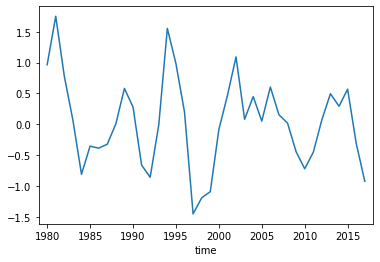

In [9]:
diff_df = slmean_df.Obs - slmean_df.Total
#diff_df = diff_df.loc[1979:]
#diff_df = diff_df.dropna()
diff_df = diff_df - diff_df.mean()
print('Sum of difference (cm) : ')
print(diff_df.sum())
print('Normalised root mean square error (cm): ')
print( np.sqrt( (diff_df**2).sum() ) / len(diff_df))
print('Normalised absolute error (cm): ')
print(np.abs(diff_df).sum() / len(diff_df))
diff_df = diff_df.rolling( 3, center=True).mean()
diff_df.plot()

,Lin_trend,Acceleration
Total,2.148250,6.732032e-02
Steric,1.669653,-1.591763e-02
GIA,0.368333,9.738876e-16
Glaciers,0.427325,1.395224e-02
Antarctica,0.332553,2.210407e-02
Greenland,0.050054,4.133371e-03
TWS,0.072815,-3.609775e-03
Nodal,-0.146147,4.217024e-02
Wind,-0.581409,-7.158280e-03
Pressure,-0.044927,1.164608e-02


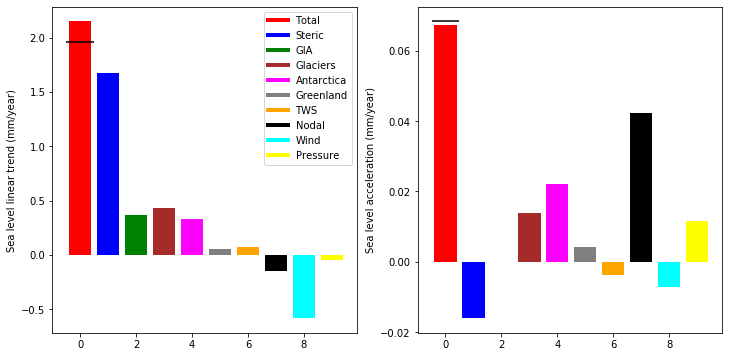

In [10]:
# Study the trend and acceleration budget
lin_trend = np.polyfit(slmean_df.index, slmean_df * 10, 1)[0,:]  # Convert from cm to mm
stat_df = pd.DataFrame(data = dict(Lin_trend = lin_trend), index=slmean_df.columns)

acceleration = 2 * np.polyfit(slmean_df.index, slmean_df * 10, 2)[0,:] # Convert from cm^2 / year to mm^2 / year
stat_df['Acceleration'] = acceleration

colors = ['red', 'blue', 'green', 'brown', 'magenta', 'grey', 'orange', 'black', 'cyan', 'yellow']
ind = np.arange(len(slmean_df.columns) - 1 )

legend_elements = []
for i in ind:
    legend_elements.append(Line2D([0], [0], color = colors[i], lw = 4, label = slmean_df.columns[i]))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(ind, lin_trend[:-1], color=colors)
ax[0].hlines(y=lin_trend[-1], xmin=-0.5, xmax=0.5, color='black')
ax[0].set_ylabel('Sea level linear trend (mm/year)')
#ax[0].set_title('tide gauge ?')

ax[1].bar(ind, acceleration[:-1], color=colors)
ax[1].hlines(y=acceleration[-1], xmin=-0.5, xmax=0.5, color='black')
ax[1].set_ylabel('Sea level acceleration (mm/year)')
#ax[1].set_title('tide gauge ?')

ax[0].legend(handles=legend_elements, loc='upper right')
#ax.set_xticks(ind)
stat_df

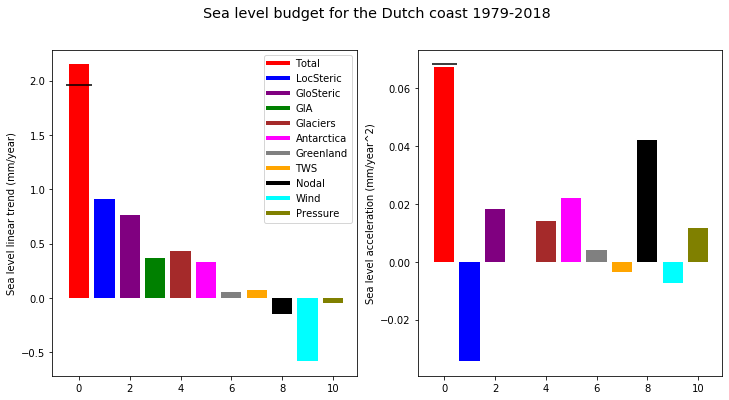

In [11]:
# Study the trend and acceleration budget
# Same as previous graph but split local and global steric effects
sl_g_df = slmean_df.copy()
sl_g_df['GloSteric'] =  slc.LevitusSL(extrap=True, extrap_back=True)
sl_g_df['Steric'] = sl_g_df['Steric'] - sl_g_df['GloSteric']
sl_g_df = sl_g_df.rename(columns={'Steric': 'LocSteric'})
# Rearange the columns for plotting
cols = sl_g_df.columns.tolist()
cols = cols[0:2] + cols[-1:] + cols[2:-1]
sl_g_df = sl_g_df[cols]

lin_trend = np.polyfit(sl_g_df.index, sl_g_df * 10, 1)[0,:]  
# Converted from cm to mm
stat_df = pd.DataFrame(data = dict(Lin_trend = lin_trend), index=sl_g_df.columns)

acceleration = 2 * np.polyfit(sl_g_df.index, sl_g_df * 10, 2)[0,:] 
# Convert from cm / year^2 to mm / year^2
stat_df['Acceleration'] = acceleration

colors = ['red', 'blue', 'purple', 'green', 'brown', 'magenta', 'grey', 
          'orange', 'black', 'cyan', 'olive']
ind = np.arange(len(sl_g_df.columns) - 1 )

legend_elements = []
for i in ind:
    legend_elements.append(Line2D([0], [0], color = colors[i], lw = 4, 
                                  label = sl_g_df.columns[i]))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(ind, lin_trend[:-1], color=colors)
ax[0].hlines(y=lin_trend[-1], xmin=-0.5, xmax=0.5, color='black')
ax[0].set_ylabel('Sea level linear trend (mm/year)')
#ax[0].set_title('tide gauge ?')

ax[1].bar(ind, acceleration[:-1], color=colors)
ax[1].hlines(y=acceleration[-1], xmin=-0.5, xmax=0.5, color='black')
ax[1].set_ylabel('Sea level acceleration (mm/year^2)')
#ax[1].set_title('tide gauge ?')

ax[0].legend(handles=legend_elements, loc='upper right')
#ax.set_xticks(ind)
fig.suptitle('Sea level budget for the Dutch coast 1979-2018', fontsize="x-large")

#!!! Modify the name if necessary:
sl_g_df.to_csv(path_outputs+'SLBudget_Steric4000m_ERA5_1979_2018_withLocSteric.csv')

#fig.savefig('./Figures/SeaLevelBudgetDutchCoast_1979_2018_ERA5.pdf', dpi=150)

Comment on the choice of steric expansion location:
It seems that using the Bay of Biscay reduces the eror compared to extended North Sea.
On the other hand Norwegian Sea increases it.

Antarctica: 
Rignot et al. 2019 -> 0.315, 1.96
IMBIE 2018 -> 0.319, 1.99
More acceleration seems better

Using pressure as a regressor improves the budget closure. N. RMS: 0.308, N. AE: 1.93 

I had forgotten to add the nodal cycle. Including it improves the fit!

Computing the wind, nodal and pressure effects (linear fit) after removing the trend from the reconstruction improves the fit compared to computing the fit using a linear trend.

Using ERA5 leads to improve the model significantly, for the period 1979 and after:
- ERA5: rmse = 0.21, ae = 1.08
- NCEP1: rmse = 0.24, ae = 1.21

Using the extended Bay of Biscay area, mostly solves the trend problem but it introduces higher rms (0.27) and ae (1.30).

The same conclusion applies to stopping the integration of steric effect at 60N instead of the standard 69N. This is because steric trend in the region 60-69 is smaller than further South (see the Steric notebook). What is the most relevent for the North Sea?

Using sea level from WAQUA forced by ERA-interim increases the rmse (0.26) and ae (1.35) compared to linear regressions to ERA5 or NCEP1 reanalysis. This might be because of sea level variations external to the domain entering the domain.

One possible difference between KNMI projections and Deltares zsm is the vertical land motion: GIA from ICE6G provides 0.36mm/y for the Dutch tide gauges while 0.45 was used in the ZSM. That is still not much: 2 mm in 20 years.

The computation of acceleration is very sensitive to the period used to compute it even for the steric effect. Also it seems very difficult to get right. For example at the Brest tide gauge, observations show a deceleration while the budget shows an acceleration.
This points toward the need to consider longer time periods to study the acceleration.

Even in the period 1950-2017 the acceleration is difficult to get right. For the Dutch coast the budget gives twice larger values than the tide gauge observations. For that period it seems that for Newlyn, Brest and Dutch coast the trend is underestimated and the acceleration is overestimated.

Acceleration for the Dutch coast is very sensitive to the wind and steric effects: check starting point in 1950 compared to 1958 -> Also check over the ERA5 period

Split global and regional steric

Outline of paper:

Closing the sea level budget in the Netherlands

20th century reanalysis

Correlation between steric and tide gauges

Why did the wind change?

Steric, regional heat uptake vs transport

Influence of leaving Wadden Sea out of the budget?